### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

### Constants

In [2]:
TOL=1e-6

# Define constants
alpha_prime = 0.839511
beta = 0.67
gamma = 0.049

### Functions

In [4]:
# Helper function for x^+ (max(x, 0))
def pos(x):
    return np.maximum(x, 0)

# Define R(x)
def R(x):
    x = np.atleast_1d(x)
    result = 0.5 * (np.sqrt(3 * (1 - x**2)) - x)
    return result.item() if result.size == 1 else result

# Define Q(x)
def Q(x):
    x = np.atleast_1d(x)
    result = np.zeros_like(x)
    mask1 = (x >= 0) & (x <= 0.5)
    mask2 = (x > 0.5) & (x <= np.sqrt(3)/2)
    mask3 = (x > np.sqrt(3)/2) & (x <= 1)
    
    result[mask1] = 1 - x[mask1]
    result[mask2] = R(x[mask2])
    result[mask3] = 0
    
    return result.item() if result.size == 1 else result

# Theta_1 is the first segment of the Theta piecewise function
def Theta_1(x):
    x1 = 0
    y1 = 0
    x2 = Q(beta)
    y2 = gamma
    return y1 + (y2 - y1) / (x2 - x1) * (x - x1)


# Theta_2 is the second segment of the Theta piecewise function
def Theta_2(x):
    x1 = Q(beta)
    y1 = gamma
    x2 = beta
    y2 = ((gamma/2 + alpha_prime*(1+beta) - 1)**2) / (1 - gamma)
    
    return y1 + (y2 - y1) / (x2 - x1) * (x - x1)

# Theta_3 is the third segment of the Theta piecewise function
def Theta_3(x):
    x1 = beta
    y1 = ((gamma/2 + alpha_prime*(1+beta) - 1)**2) / (1 - gamma)
    x2 = 1
    y2 = 2-2*alpha_prime
    
    return y1 + (y2 - y1) / (x2 - x1) * (x - x1)

# Define Theta(x) - piecewise linear through specified points
def Theta(x):
    x = np.atleast_1d(x)
    
    # Key points
    x0, x1, x2, x3 = 0, Q(beta), beta, 1
    
    result = np.zeros_like(x)
    
    # Theta_1: from (x0, y0) to (x1, y1)
    mask1 = (x >= x0) & (x <= x1)
    result[mask1] = Theta_1(x[mask1])
    
    # Theta_2: from (x1, y1) to (x2, y2)
    mask2 = (x > x1) & (x <= x2)
    result[mask2] = Theta_2(x[mask2])
    
    # Theta_3: from (x2, y2) to (x3, y3)
    mask3 = (x > x2) & (x <= x3)
    result[mask3] = Theta_3(x[mask3])
    
    return result.item() if result.size == 1 else result

# Define Lambda(x)
def Lambda(x):
    numerator = (0.5 * Theta(Q(x)) + alpha_prime * (1 + x) - 1)**2
    denominator = 1 - Theta(Q(x))
    return numerator / denominator

# Define f^*(x)
def f_star(x):
    R_x_pos = pos(R(x))
    term1 = 1 - Lambda(R_x_pos)
    term2 = 1 - Theta(Q(R_x_pos) - pos(x))
    return np.sqrt(term1 * term2)

# Define r_1(g) - for g in [0, beta]
def r_1(g):
    g_pos = pos(g)
    numerator = 2 - Theta(Q(g_pos)) + 2 * np.sqrt(Theta(g_pos) * (1 - Theta(Q(g_pos))))
    denominator = 2 * (1 + g)
    return numerator / denominator

# Define r_2(g) - for g in [beta, 1]
def r_2(g):
    g_pos = pos(g)
    numerator = 2 - Theta(Q(g_pos)) + 2 * np.sqrt(Lambda(g_pos) * (1 - Theta(Q(g_pos))))
    denominator = 2 * (1 + g)
    return numerator / denominator


# Define r_3(g) - for g in [-1, R(beta)]
def r_3(g):
    g_pos = pos(g)
    f_g = f_star(g)
    numerator = 1 + f_g**2 + 2 * np.sqrt(Theta(g_pos)) * f_g
    denominator = 2 * (1 + g)
    return numerator / denominator


### Plot approximation ratios

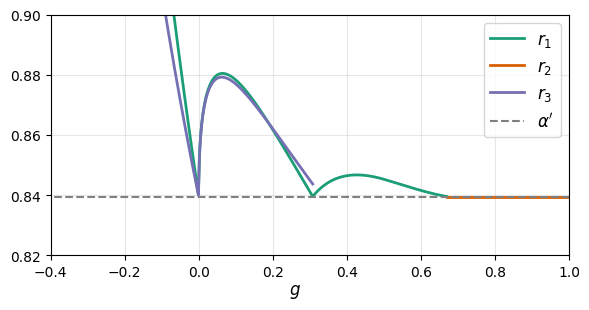

In [24]:
# Create single plot with all four functions
fig, axs = plt.subplots(1, 1, figsize=(6, 3), sharex=True, sharey=True)

# Plot r_1 over [0, beta]
g1 = np.linspace(-1+TOL, beta, 1001)
g2 = np.linspace(beta, 1, 1001)
g3 = np.linspace(-1+TOL, R(beta), 1001)

colors = colormaps.get_cmap('Dark2').colors

axs.plot(g1, r_1(g1), color=colors[0], linewidth=2, label=r'$r_1$')
axs.plot(g2, r_2(g2), color=colors[1], linewidth=2, label=r'$r_2$')
axs.plot(g3, r_3(g3), color=colors[2], linewidth=2, label=r'$r_3$')

axs.hlines(alpha_prime, -1, 1, colors='gray', linestyles='dashed', label=r'$\alpha^{\prime}$')
axs.set_xlim(-.4, 1)
axs.set_ylim(0.82, .9)
axs.grid(True, alpha=0.3)
axs.legend(fontsize=12)

# Adjust spacing between plots
fig.tight_layout()  # automatic layout adjustment
fig.subplots_adjust(wspace=0.1, hspace=0.2)  # fine-tune if needed

# Add shared x label
fig.supxlabel(r'$g$', fontsize=12, y=-0.02)
# savefig
plt.savefig('fig/r_functions.pdf', bbox_inches='tight', dpi=720)
plt.show()


### Verification of proofs

##### $r_{1d}$

In [88]:
# Derivative of Theta_2 (constant since it's linear)
def Theta_2_prime(x):
    x1 = Q(beta)
    y1 = gamma
    x2 = beta
    y2 = ((gamma/2 + alpha_prime*(1+beta) - 1)**2) / (1 - gamma)
    
    return (y2 - y1) / (x2 - x1)

# Derivative of R
def R_prime(x):
    return 0.5 * (-3*x / np.sqrt(3*(1 - x**2)) - 1)

# Define h(g)
def h(g):
    return Theta_2(g) * (1 - Theta_2(R(g)))

# Derivative of h using the product rule and chain rule
def h_prime(g):
    # h(g) = Theta_2(g) * (1 - Theta_2(R(g)))
    # h'(g) = Theta_2'(g) * (1 - Theta_2(R(g))) + Theta_2(g) * (-Theta_2'(R(g)) * R'(g))
    term1 = Theta_2_prime(g) * (1 - Theta_2(R(g)))
    term2 = Theta_2(g) * (-Theta_2_prime(R(g)) * R_prime(g))
    return term1 + term2

# The full function
def r_1d_n(g):
    sqrt_h = np.sqrt(h(g))
    term1 = (1 + g) * (-Theta_2_prime(R(g)) * R_prime(g) + h_prime(g) / sqrt_h)
    term2 = -2 + Theta_2(R(g)) - 2 * sqrt_h
    return term1 + term2


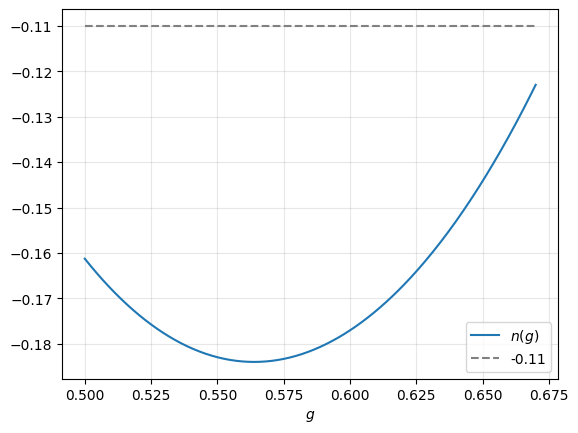

In [92]:
g_tests = np.linspace(1/2, beta, 300)
for g in g_tests:
    assert r_1d_n(g) < -.11
plt.plot(g_tests, r_1d_n(g_tests), label=r'$n(g)$')
plt.hlines(-.11, g_tests[0], g_tests[-1], colors='grey', linestyles='dashed', label='-0.11')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel(r'$g$')
plt.show()

##### $r_{3d}$

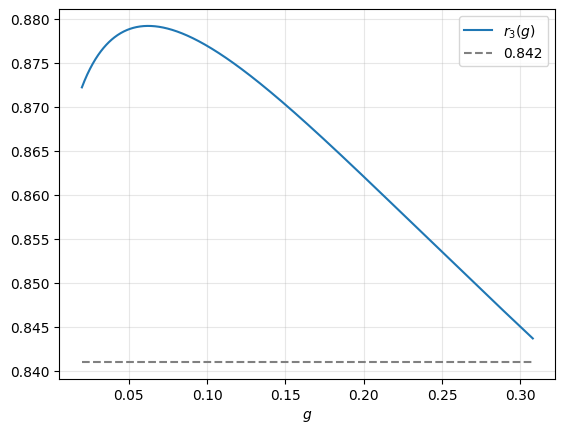

In [16]:
g_tests = np.linspace(0.02, Q(beta), 1000)
for g in g_tests:
    assert r_3(g) > 0.842
plt.plot(g_tests, r_3(g_tests), label=r'$r_3(g)$')
plt.hlines(0.841, g_tests[0], g_tests[-1], colors='grey', linestyles='dashed', label='0.842')
plt.grid(True,  alpha=0.3)
plt.legend(loc='upper right')
plt.xlabel(r'$g$')
plt.show()